# Module 3: MLOps and Real World Scenarios: Get Hands-On

## Part 2 - MLOps Deployment with Computer Vision
## COVID Mask Detection Classification and Introduction to Workflows with MLRun and KubeFlow

This notebook demonstrates a machine learning workflow that builds and trains a model that classifies whether a person is wearing a mask or not, optimizes the model's performance using ONNX, and serves the model in real-time . All the operations are auto-logged to MLRun with all the metadata.

**Tutorial Steps:**
- [**Install MLRun and Dependencies**](#install-mlrun-dependencies)
- [**Setup the Project**](#mlrun-project-setup)
- [**Download the Data**](#download-data)
- [**Write the Training and Evaluation Code**](#training-and-evaluation)
- [**Create MLRun Function For Training and Evaluation**](#code-to-function-mlrun-training-and-evaluation)
- [**Run Training and Evaluation**](#run-training-and-evaluation)
- [**Serving the Model**](#model-serving)
- [**Build an Automated Pipeline with KubeFlow**](#automated-kubeflow-pipeline)

<a id="install-mlrun-dependencies"></a>
## Install MLRun and Dependencies

This tutorial expects the MLRun backend service to be running on a Kubernetes Cluster.

**Note:** Throughout this tutorial, the GKE Cluster which was set up in Part 0 will be used to run the MLRun backend service.

In [13]:
# Ensure that Python 3 (preferred version: 3.9.x) and pip 22.x.y are installed on the machine.

# Check the Python version.
!python --version

# Check the pip version.
!python -m pip --version

Python 3.9.13
pip 22.3.1 from /opt/conda/lib/python3.9/site-packages/pip (python 3.9)


In [14]:
# Install MLRun, TF.Keras, and other dependencies.

# Note: This cell needs to be run only once. The notebook needs to be restarted after a successful installation.

!pip install mlrun tensorflow~=2.9.0 typing-extensions


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


**Restart the notebook kernel after the pip installation.**

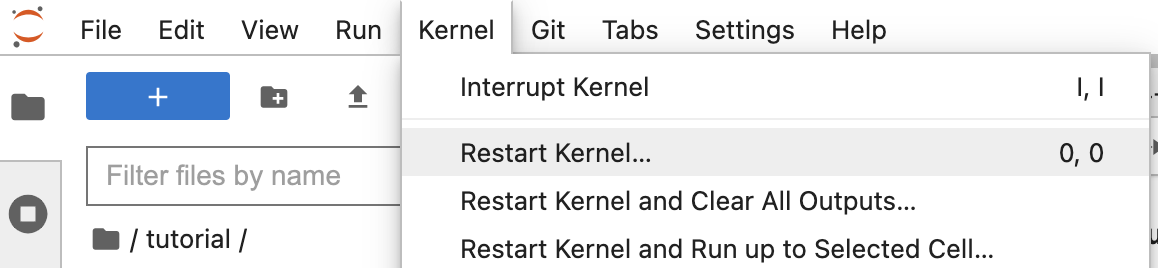

<a id="mlrun-project-setup"></a>
## Setup the Project

Create an MLRun project using `mlrun.get_or_create_project()` (make sure to load the desired project in case one already exists).

In [15]:
# Import the required Python packages.
import mlrun
import os

# Set MLRun Project's name.
project_name = "mask-detection"

# Create the MLRun Project.
project = mlrun.get_or_create_project(name=project_name, context="./", user_project=True)

> 2023-08-04 16:51:37,370 [info] Project loaded successfully: {'project_name': 'mask-detection'}


<a id="download-data"></a>
## Download the Data

### Import Open Archive Serverless Function from Function Hub 

The images can be downloaded using `open_archive` - a Function Hub Serverless Function. The Open Archive Serverless Function can be imported using `mlrun.import_function()`.

In [16]:
# Import the Open Archive Function Hub Serverless Function.
open_archive_function = mlrun.import_function("hub://open_archive")

# Print the Open Archive Function Hub Serverless Function's documentation.
open_archive_function.doc()

function: open-archive
Open a file/object archive into a target directory
default handler: open_archive
entry points:
  open_archive: Open a file/object archive into a target directory
Currently supports zip and tar.gz
    context(MLClientCtx)  - function execution context, default=
    archive_url(DataItem)  - url of archive file , default=
    subdir(str)  - path within artifact store where extracted files are stored, default=content/
    key(str)  - key of archive contents in artifact store, default=content
    target_path(str)  - file system path to store extracted files, default=None


### Download the Images

In [18]:
# Setup the archive url for downloading the dataset images.
archive_url = mlrun.get_sample_path("data/prajnasb-generated-mask-detection/prajnasb_generated_mask_detection.zip")

# Set the path to download the images data to.
dataset_path = os.environ.get('PWD', None)+'/data/'

# Run the Open Archive Function Hub Serverless Function using the 'open_archive' handler.
open_archive_run = open_archive_function.run(
    name='download-data',
    handler='open_archive',
    inputs={'archive_url': archive_url},
    params={'target_path': dataset_path},
    local=True
)

> 2023-08-04 16:56:54,875 [info] Storing function: {'name': 'download-data', 'uid': 'a6c43e16bf914f9bb64048dec0a520b8', 'db': 'http://mlrun-api:8080'}
> 2023-08-04 16:56:54,986 [info] downloading https://s3.wasabisys.com/iguazio/data/prajnasb-generated-mask-detection/prajnasb_generated_mask_detection.zip to local temp file
> 2023-08-04 16:56:57,397 [info] Logging artifact to /home/jovyan/data/


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mask-detection-jovyan,...c0a520b8,0,Aug 04 16:56:54,completed,download-data,kind=owner=jovyanhost=mlrun-jupyter-67f5bb95d7-mqchv,archive_url,target_path=/home/jovyan/data/,,content


> 2023-08-04 16:56:57,527 [info] Run execution finished: {'status': 'completed', 'name': 'download-data'}


<a id="training-and-evaluation"></a>
## Write the Training and Evaluation Code

In [19]:
framework = "tf-keras"

### TF.Keras

The code is taken from the Python file [training-and-evaluation.py](tf-keras/training-and-evaluation.py), which is classic and straightforward.
1. Use `_get_datasets` to get the training and validation datasets (for evaluation - the evaluation dataset).
2. Use `_get_model` to build the classifier - simple Transfer Learning from MobileNetV2 (`keras.applications`).
3. Call `train` to train the model.
4. Call `evaluate` to evaluate the model.

Taking this code one step further is **MLRun**'s framework for `tf.keras`:

```
# Apply MLRun's interface for tf.keras.
mlrun_tf_keras.apply_mlrun(model=model, context=context, ...)
```

With just one line of code, MLRun seamlessly provides **automatic logging** and **distributed training** by wrapping the `fit` and `evaluate` methods of `tf.keras.Model`.

In addition, there is the `TFKerasModelHandler` class that is being returned from `apply_mlrun`. This class supports loading, saving, and logging `tf.keras` models with ease, enabling easy versioning of the model and its results, artifacts, and custom objects. 

By default, the model is loaded and logged automatically by `apply_mlrun`.

<a id="code-to-function-mlrun-training-and-evaluation"></a>
## Create the MLRun Function

MLRun's `mlrun.code_to_function()` can be used to create an MLRun Function from the `training-and-evaluation.py` code.

It should be noted that the MLRun Function will have two handlers: `train` and `evaluate`.

In [20]:
# Create the Serverless Function for `training-and-evaluation` using the above-mentioned Python code and 'code_to_function'.
training_and_evaluation_function = mlrun.code_to_function(
    filename=os.path.join(framework, "training-and-evaluation.py"),
    name="training-and-evaluation",
    kind="job",
    image="mlrun/ml-models"
)

# Mount the function.
training_and_evaluation_function.apply(mlrun.auto_mount())
training_and_evaluation_function.spec.disable_auto_mount=False

> 2023-08-04 17:25:20,262 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': 'tf-keras', 'error': '/home/jovyan/tutorial/tf-keras'}


<a id="run-training-and-evaluation"></a>
## Run Training and Evaluation

### Train the Model

Training will be done using the `train` handler. The desired hyperparameters will be passed and the returned run object will be retained in order to pass the trained model to the evaluation. 

Unlike running the `open_archive` function, the training will be performed as a **job** on the **cluster** and not locally. 

> **Notice** that now the `local` attribute is set to `False` (this is its default value), which means the function will be run on the cluster.

In [21]:
training_run = training_and_evaluation_function.run(
    name="training",
    handler="train",
    params={
        "dataset_path": dataset_path,
        "batch_size": 32,
        "learning_rate": 1e-4,
        "epochs": 1
    },
    local=False
)

> 2023-08-04 17:31:05,756 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2023-08-04 17:31:05,780 [info] Storing function: {'name': 'training', 'uid': 'f56ae59ef2ef4b718ee9073c6abad2c8', 'db': 'http://mlrun-api:8080'}
> 2023-08-04 17:31:06,038 [info] Job is running in the background, pod: training-c4gmm
2023-08-04 17:31:12.143520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-04 17:31:12.143572: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-04 17:31:15.973480: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mask-detection-jovyan,...6abad2c8,0,Aug 04 17:31:11,completed,training,kind=jobowner=jovyanmlrun/client_version=1.4.0mlrun/client_python_version=3.9.13host=training-c4gmm,,dataset_path=/home/jovyan/data/batch_size=32learning_rate=0.0001epochs=1,dataset_path=/home/jovyan/data/batch_size=32learning_rate=0.0001epochs=1lr=9.999999747378752e-05training_loss=0.13262653350830078training_accuracy=1.0037117004394531validation_loss=0.10589540667004055validation_accuracy=0.9891304439968533,training_loss.htmltraining_accuracy.htmlvalidation_loss.htmlvalidation_accuracy.htmlloss_summary.htmlaccuracy_summary.htmllr_values.htmlmodel


> 2023-08-04 17:32:43,587 [info] Run execution finished: {'status': 'completed', 'name': 'training'}


When the training is done, there will be a list of all the <span style="background:lightgreen">artifacts created</span> in MLRun during the training run. All the loss and metrics graphs will also be stored in MLRun along with the model weights and custom objects.

### Evaluate the Model

Evaluating the model requires the trained model. In order to get the model that was just trained, the training run object `training_run` can be used.

In [22]:
evaluation_run = training_and_evaluation_function.run(
    name="evaluating",
    handler="evaluate",
    params={
        "model_path": training_run.outputs['model'],
        "dataset_path": dataset_path,
        "batch_size": 32
    }
)

> 2023-08-04 17:33:26,651 [info] Storing function: {'name': 'evaluating', 'uid': 'f66f0bfa071846a9b17b6ef32dd3704d', 'db': 'http://mlrun-api:8080'}
> 2023-08-04 17:33:26,861 [info] Job is running in the background, pod: evaluating-js5j4
2023-08-04 17:33:31.723758: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-04 17:33:31.723802: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-04 17:33:34.793018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-04 17:33:34.793071: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-04 17:33:34.793101: I 

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
mask-detection-jovyan,...2dd3704d,0,Aug 04 17:33:31,completed,evaluating,kind=jobowner=jovyanmlrun/client_version=1.4.0mlrun/client_python_version=3.9.13host=evaluating-js5j4,,model_path=store://artifacts/mask-detection-jovyan/mask_detector:f56ae59ef2ef4b718ee9073c6abad2c8dataset_path=/home/jovyan/data/batch_size=32,model_path=store://artifacts/mask-detection-jovyan/mask_detector:f56ae59ef2ef4b718ee9073c6abad2c8dataset_path=/home/jovyan/data/batch_size=32evaluation_loss=0.10665385667667833evaluation_accuracy=0.9876453488372093,evaluation_loss.htmlevaluation_accuracy.html


> 2023-08-04 17:34:11,483 [info] Run execution finished: {'status': 'completed', 'name': 'evaluating'}


<a id="model-serving"></a>
## Serving the Model

The trained model will be deployed as a Nuclio Serverless Function.

The function will take an image url and respond back with the probability that the person in the image is wearing a mask or not.

### Write the Serving Code
The code is taken from the Python file [serving.py](tf-keras/serving.py).

The data will go through the following structure:
1. `resize` - Read the URL into an array and resize it to 224x224.
2. `preprocess` - Use MobileNetV2 preprocessing function.
3. `mlrun.frameworks.tf_keras.TFKerasModelServer` - Infer the inputs through the model and return the predictions. It can be imported from:
    ```
    from mlrun.frameworks.tf_keras import TFKerasModelServer
    ```
    This class can be inherited and its pre-process, post-process, predict, and explain methods can be overridden. This demo will use the defaults to showcase the topology feature of the serving functions.
4. `post-process` - Parse the prediction probabilities and wrap them in a dictionary with which to respond.


### Create the Serving Pipeline
Use `mlrun.code_to_function()` again to create the MLRun Serverless Function as used for Training and Evaluation.

In [24]:
# Create the Serving Serverless Function.
serving_function = mlrun.code_to_function(
    filename=os.path.join(framework, "serving.py"),
    name="serving", 
    kind="serving", 
    image="mlrun/ml-models",
    with_doc=False
)

# Increase the time limit as the image may take long time to be downloaded.
serving_function.spec.readiness_timeout = 60 * 20  # 20 minutes.

> 2023-08-04 17:44:25,062 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': 'tf-keras', 'error': '/home/jovyan/tutorial/tf-keras'}


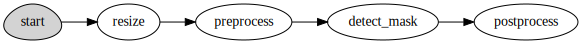

In [25]:
# Set the async flow (DAG) serving topology and get the graph object.
graph = serving_function.set_topology(topology="flow", engine="async")

# Choose the ModelServer according to the selected framework.
model_server_class = ("mlrun.frameworks.tf_keras.TFKerasModelServer")

# Build the serving graph.
graph.to(handler="resize", name="resize")\
     .to(handler="preprocess", name="preprocess")\
     .to(class_name=model_server_class, name="detect_mask", model_path=project.get_artifact_uri("mask_detector"))\
     .to(handler="postprocess", name="postprocess").respond()

# Plot to graph.
graph.plot(rankdir='LR')

### Test the Serving Pipeline
The serving pipeline should be tested before deploying it. First, let's declare the image urls that will be used to test and a function to print the image and the prediction.

In [28]:
# Import the required Python packages for plotting images.
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# The local mock server is searching to import the functions, so here the functions are simply imported from the files.
import sys
sys.path.insert(0, os.path.abspath(f"./{framework}"))
from serving import resize, preprocess, postprocess

In [29]:
# Initialize the predictions headers.
classes = ["with mask", "without mask"]

In [30]:
# Specify the image urls to use in the tests.
image_urls = [
    'https://st.depositphotos.com/1144472/2003/i/950/depositphotos_20030237-stock-photo-cheerful-young-man-over-white.jpg',  # Without mask
    'https://icons8.com/wp-content/uploads/2020/04/man-in-face-mask.jpg'   # With mask
]

In [33]:
# Function to print the image along with the prediction score.
def print_image_classification(image_url: str, prediction: dict):
    # Draw the image.
    response = requests.get(image_url)
    plt.imshow(Image.open(BytesIO(response.content)))
    
    # Print the prediction.
    print(f"Classified: {classes[prediction['class']]}\n")
    print(f"With mask probability:    {prediction['with_mask']}")
    print(f"Without mask probability: {prediction['without_mask']}")

In [35]:
# Create local server for mocking.
server = serving_function.to_mock_server()

> 2023-08-04 17:52:59,939 [info] model detect_mask was loaded


1/1 [==============================] - 1s 995ms/step
Classified: without mask

With mask probability:    0.3250398635864258
Without mask probability: 0.6749601364135742


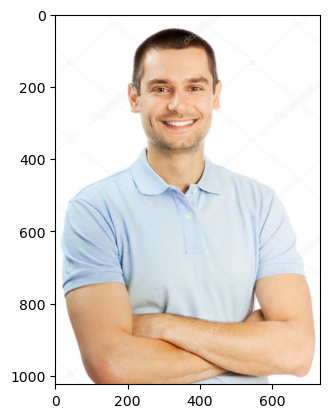

In [36]:
# Test image prediction.
print_image_classification(
    image_url=image_urls[0], 
    prediction=server.test(path='/predict', body={"data_url": [image_urls[0]]})
)

1/1 [==============================] - 0s 59ms/step
Classified: with mask

With mask probability:    0.9402291774749756
Without mask probability: 0.05977078154683113


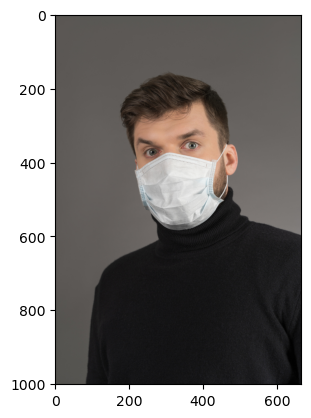

In [38]:
# Test another image prediction.
print_image_classification(
    image_url=image_urls[1], 
    prediction=server.test(path='/predict', body={"data_url": [image_urls[1]]})
)

In [40]:
# Mount the Serving Serverless Function.
serving_function.apply(mlrun.auto_mount())
serving_function.spec.disable_auto_mount=False

In [41]:
# Deploy the Serving Serverless Function.
project.deploy_function(serving_function)

> 2023-08-04 17:55:21,891 [warning] it is recommended to use k8s secret (specify secret_name), specifying the aws_access_key/aws_secret_key directly is unsafe
> 2023-08-04 17:55:21,895 [info] Starting remote function deploy
2023-08-04 17:55:22  (info) Deploying function
2023-08-04 17:55:22  (info) Building
2023-08-04 17:55:22  (info) Staging files and preparing base images
2023-08-04 17:55:22  (info) Building processor image
2023-08-04 17:55:27  (info) Build complete
2023-08-04 17:55:45  (info) Function deploy complete
> 2023-08-04 17:55:52,328 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-mask-detection-jovyan-serving.mlrun.svc.cluster.local:8080'], 'external_invocation_urls': ['34.135.160.246:31880']}


DeployStatus(state=ready, outputs={'endpoint': 'http://34.135.160.246:31880', 'name': 'mask-detection-jovyan-serving'})

> 2023-08-04 17:56:36,654 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-mask-detection-jovyan-serving.mlrun.svc.cluster.local:8080/predict'}
Classified: without mask

With mask probability:    0.3243659734725952
Without mask probability: 0.67563396692276


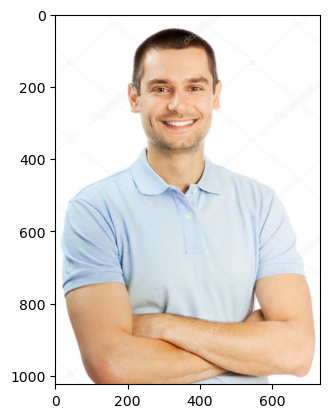

In [42]:
# Invoke the Real-Time Serving Serverless Function.
print_image_classification(
    image_url=image_urls[0], 
    prediction=serving_function.invoke(path='/predict', body={"data_url": [image_urls[0]]})
)

<a id="automated-kubeflow-pipeline"></a>
## Build an Automated Pipeline with KubeFlow

The following section discusses how to package an MLRun Project and how to run an automated pipeline to train, evaluate, optimize, and serve the mask detection model using the MLRun Serverless Functions prepared.

### Import the ONNX Serverless Function
* `onnx_utils` - ONNX integration in MLRun provides some utility functions for ONNX framework and optimizing and converting models from different frameworks to ONNX.

In [43]:
# Import the `onnx_utils` function to optimize the model.
project.set_function("hub://onnx_utils", name="onnx-utils")

In [44]:
# Mount all the required Serverless Functions.
def mount_functions(functions_list: list):
    for function_name in functions_list:
        function_object = project.get_function(function_name)
        function_object.apply(mlrun.auto_mount()) 
        function_object.spec.disable_auto_mount=False
        project.set_function(function_object)
        print("function {} mounted".format(function_name))
        
project_functions = ["training-and-evaluation","serving","open-archive","onnx-utils"]
        
mount_functions(project_functions)

> 2023-08-04 18:06:56,309 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': './', 'error': '/home/jovyan/tutorial'}
function training-and-evaluation mounted
> 2023-08-04 18:06:56,314 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': './', 'error': '/home/jovyan/tutorial'}
function serving mounted
> 2023-08-04 18:06:56,318 [warning] Failed to add git metadata, ignore if path is not part of a git repo.: {'path': './', 'error': '/home/jovyan/tutorial'}
function open-archive mounted
function onnx-utils mounted


## Write and Save the Workflow

Majorly, there will be two functions used:
* `mlrun.run_function()` - This ensures that a task is run as part of KubeFlow pipeline. Using this function to run the training and the rest of the functions will ensure that if the function is using output from another function, it will run only if the relying function is done running.
* `mlrun.deploy_function()` - Deploy a real-time (Nuclio-based) function,

> **Note** The serving graph will now serve an ONNX model (not a tf.keras model like before), so `mlrun.frameworks.onnx.ONNXModelServer` will be used.

In [45]:
%%writefile workflow.py
import mlrun
from kfp import dsl

# Configure the Mask Detection Pipeline with KubeFlow.
@dsl.pipeline(name="Mask Detection Pipeline")
def kfpipeline(
    archive_url: str,
    dataset_path: str,
    epochs: int,
    batch_size: int,
    lr: float,
    download_data_flag: int = 1
):
    # Get the MLRun Project object.
    project = mlrun.get_current_project()

    ###########################################################
    ###############    Download the Dataset.    ###############
    ###########################################################
    # Download only if needed (meaning if 'download_data_flag' = 1).
    with dsl.Condition(download_data_flag == 1) as download_data_condition:
        # Run it using the 'open_archive' handler.
        open_archive_run = mlrun.run_function(
            function="open-archive",
            handler="open_archive",
            name="download_data",
            inputs={"archive_url": archive_url},
            params={"target_path": dataset_path}
        )

    ####################################################
    ###############    Train a model.    ###############
    ####################################################    
    # Train the model using the 'train' handler.
    training_run = mlrun.run_function(
        function="training-and-evaluation",
        handler="train",
        name="training",
        params={
            "dataset_path": dataset_path,
            "batch_size": batch_size,
            "learning_rate": lr,
            "epochs": epochs
        },
        outputs=["model"]
    ).after(download_data_condition)

    ###################################################################
    ###############    Convert to ONNX and optimize.    ###############
    ###################################################################
    # Run optimization using the 'to_onnx' handler.
    to_onnx_run = mlrun.run_function(
        function="onnx-utils",
        handler="to_onnx",
        name="optimizing",
        params={
            "model_path": training_run.outputs['model'],
            "onnx_model_name": 'onnx_mask_detector'
        },
        outputs=["model"]
    )

    #########################################################
    ###############    Evaluate the model.    ###############
    #########################################################
    # Evaluate the model using the 'evaluate' handler:
    evaluation_run = mlrun.run_function(
        function="training-and-evaluation",
        handler="evaluate",
        name="evaluating",
        params={
            "model_path": training_run.outputs['model'],
            "dataset_path": dataset_path,
            "batch_size": batch_size
        }
    )

    ################################################################################
    ###############    Deploy the model as a Serverless Function.    ###############
    ################################################################################
    # Get the function.
    serving_function = project.get_function("serving")
    
    # Increase the time limit as the image may take long time to be downloaded.
    serving_function.spec.readiness_timeout = 60 * 20  # 20 minutes.
    
    # Set the serving topology and get the graph object.
    graph = serving_function.set_topology("flow", engine="async")
    
    # Build the serving graph.
    graph.to(handler="resize", name="resize")\
         .to(handler="preprocess", name="preprocess")\
         .to(class_name="mlrun.frameworks.onnx.ONNXModelServer", name="onnx_mask_detector", model_path=str(to_onnx_run.outputs["model"]))\
         .to(handler="postprocess", name="postprocess").respond()
    
    # Set the desired requirements.
    serving_function.with_requirements(requirements=["onnxruntime~=1.14.0", "onnxoptimizer~=0.3.0", "protobuf<=3.20.1"])
    
    # Deploy the serving function.
    mlrun.deploy_function("serving")

Overwriting workflow.py


In [46]:
# Register the workflow file.
workflow_name = "mask_detection_workflow"
project.set_workflow(workflow_name, "workflow.py")

# Save the MLRun Project.
project.save()

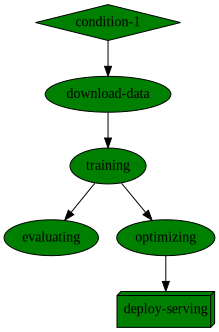

uid,start,state,name,parameters,results
...1959983e,Aug 04 18:19:04,completed,optimizing,model_path=store://artifacts/mask-detection-jovyan/mask_detector:6dfdec9e-c78c-4851-85c5-1925ef75ed0fonnx_model_name=onnx_mask_detector,
...a0c9fc9c,Aug 04 18:19:03,completed,evaluating,model_path=store://artifacts/mask-detection-jovyan/mask_detector:6dfdec9e-c78c-4851-85c5-1925ef75ed0fdataset_path=/home/jovyan/data/batch_size=32,model_path=store://artifacts/mask-detection-jovyan/mask_detector:6dfdec9e-c78c-4851-85c5-1925ef75ed0fdataset_path=/home/jovyan/data/batch_size=32evaluation_loss=0.03899203881967899evaluation_accuracy=0.9927325581395349
...b39a84d7,Aug 04 18:16:13,completed,training,dataset_path=/home/jovyan/data/batch_size=32learning_rate=0.001epochs=3,dataset_path=/home/jovyan/data/batch_size=32learning_rate=0.001epochs=3lr=9.999999747378752e-05training_loss=0.05389833450317383training_accuracy=1.0004615783691406validation_loss=0.03767158918910556validation_accuracy=0.9963767793443468
...b7a0d903,Aug 04 18:15:47,completed,download-data,target_path=/home/jovyan/data/,


6dfdec9e-c78c-4851-85c5-1925ef75ed0f

In [47]:
dataset_path = os.environ.get('PWD', None)+'/data/'

# Run the workflow and watch the execution.
project.run(
    name=workflow_name,
    arguments={
        "archive_url": mlrun.get_sample_path("data/prajnasb-generated-mask-detection/prajnasb_generated_mask_detection.zip"),
        "dataset_path": dataset_path,
        "epochs": 3,
        "batch_size": 32, 
        "lr": 1e-3,
        "download_data_flag": 1
    },
    watch=True
)

### Test the Pipeline

> 2023-08-04 18:21:05,025 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-mask-detection-jovyan-serving.mlrun.svc.cluster.local:8080/predict'}
Classified: without mask

With mask probability:    0.07537931203842163
Without mask probability: 0.9246206879615784


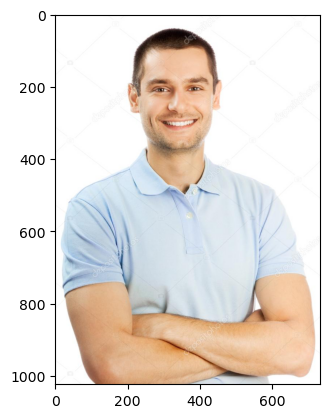

In [48]:
# Test the Pipeline by invoking the Serving Serverless Function.
print_image_classification(
    image_url=image_urls[0], 
    prediction=project.get_function("serving").invoke(path='/predict', body={"data_url": [image_urls[0]]})
)

> 2023-08-04 18:21:12,196 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-mask-detection-jovyan-serving.mlrun.svc.cluster.local:8080/predict'}
Classified: with mask

With mask probability:    0.9391338229179382
Without mask probability: 0.06086614355444908


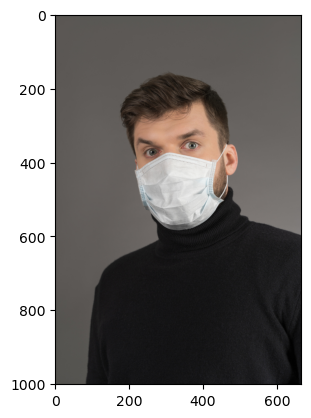

In [49]:
# Test the Pipeline with another image by invoking the Serving Serverless Function.
print_image_classification(
    image_url=image_urls[1], 
    prediction=project.get_function("serving").invoke(path='/predict', body={"data_url": [image_urls[1]]})
)

## Part 2 Completed!
Congratulations! You've completed Part 2 of the Module 3: MLOps and Real World Scenarios. Proceed to Part 3 to try out MLOps Deployment with NLP.